### Упражнение 1

* Скачайте с портала Открытых Данных производственный календарь России: https://data.gov.ru/opendata/7708660670-proizvcalendar
* На его основе определите соответствующий календарь в Pandas: `RussianBusinessCalendar(AbstractHolidayCalendar)`
* С помощью полученного в пункте выше календаря и модуля `pd.offsets` создайте DataFrame one-hot календарных признаков:
    * День недели
    * Месяц
    * Выходной день
    * Праздничный день
    * Предпраздничный рабочий день
    * Последний день месяца
    * Последний рабочий день месяца
    * Предновогодний выходной день

In [66]:
import re
import datetime # для работы со временем 
import requests
import numpy as np # уже знакомые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, EasterMonday, next_monday
from pandas.tseries.offsets import DateOffset, Day
pd.set_option('display.max_columns', None)

%matplotlib inline

In [68]:

class RussianBusinessCalendar(AbstractHolidayCalendar):
    
    # Вводим переменные по всем выходным дня и сокращённым предпразничным дням из производственного каледаря    
    def __init__(self, link):
        link = link
        a = requests.get(link)
        with open(r'C:\Users\wirm1\наработки\Работа с данными на Python\4 день\HW 4\proizv_cal.csv', 'wb') as f:
            f.write(a.content)
        proizv_calendar_gov = pd.read_csv(r'C:\Users\wirm1\наработки\Работа с данными на Python\4 день\HW 4\proizv_cal.csv')
        proizv_calendar_gov.loc[22, 'Март'] = '6,7*,8,13,14,20,21,27,28'
        proizv_calendar_gov.set_index(['Год/Месяц'], inplace = True)
        proizv_calendar_gov = proizv_calendar_gov[proizv_calendar_gov.columns[:-5]]
        
        # Выходные дни
        hol_temp = pd.DataFrame(columns = proizv_calendar_gov.columns, index = proizv_calendar_gov.index)
        for column in hol_temp.columns:
            hol_temp[column] = proizv_calendar_gov[column].apply(lambda x: re.sub(r'\d{1,2}\*\,|\,\d{1,2}\*|\+', '', x))
        self.holidays_pc = [pd.Timestamp(datetime.datetime(y,j+1, int(i))) \
                            for y in hol_temp.index \
                                for j in range(12) \
                                    for i in hol_temp.loc[y,hol_temp.columns[j]].split(',')]
        
        # Сокращенные предпраздничные
        pre_hol_temp = pd.DataFrame(columns = proizv_calendar_gov.columns, index = proizv_calendar_gov.index)
        for column in pre_hol_temp.columns:
            pre_hol_temp[column] = proizv_calendar_gov[column].apply(lambda x: re.sub(r'\*','',','.join(re.findall(r'\d{1,2}\*',x))) if '*' in x else np.nan )
        self.pre_hol_pc = [pd.Timestamp(datetime.datetime(j, r+1,  int(i))) for j in pre_hol_temp.index \
                            for r in pre_hol_temp.loc[j].index.get_indexer(pre_hol_temp.loc[j][pre_hol_temp.loc[j].notna()].index)  \
                                for i in pre_hol_temp.loc[j, pre_hol_temp.columns[r]].split(',')]
        
        # Даты праздников
        self.holidays_rus = [(1,1), (1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8), (2,23), (3, 8), 
                        (5, 1), (5, 9), (6, 12), (11, 4)
                       ]
    
    # Указываем конкретные даты праздников в заданный год
    def dates_of_russian_holidays(self, year):
        rus_hol = [pd.Timestamp(datetime.datetime(y, i[0], i[1])) for y in [year, year+1] for i in self.holidays_rus]
        return rus_hol
        
    
    start_date = datetime.datetime(proizv_calendar_gov.index[0], 1, 1)
    
    end_date = datetime.datetime(proizv_calendar_gov.index[-1], 12, 31)
    
    weekmask = 'Mon Tue Wed Thu Fri'
    
    rules = [Holiday('Рабочая суббота', month=3, day=7, year=2020, offset=Day(1)), 
             Holiday('Новогодние каникулы1', month = 1, day = 1), 
             Holiday('Новогодние каникулы2', month = 1, day = 2), 
             Holiday('Новогодние каникулы3', month = 1, day = 3), 
             Holiday('Новогодние каникулы4', month = 1, day = 4), 
             Holiday('Новогодние каникулы5', month = 1, day = 5), 
             Holiday('Новогодние каникулы6', month = 1, day = 6), 
             Holiday('Новогодние каникулы8', month = 1, day = 8), 
             Holiday('Рождество Христово', month = 1, day = 7), 
             Holiday('День защитника Отечества', month = 2, day = 23, observance=next_monday), 
             Holiday('Международный женский день', month = 3, day = 8, observance=next_monday), 
             Holiday('Праздник весны и труда', month = 5, day = 1, observance=next_monday), 
             Holiday('Праздник весны и труда_20_1', month = 5, day = 4, year = 2020), 
             Holiday('Праздник весны и труда_20_2', month = 5, day = 5, year = 2020),
             Holiday('День победы', month = 5, day = 9, observance=next_monday), 
             Holiday('День России', month = 6, day = 12, observance=next_monday), 
             Holiday('День народного единства', month = 11, day = 4, observance=next_monday)
            ]
    
    
calendar = RussianBusinessCalendar('https://data.gov.ru/sites/default/files/data-20181017t0930-structure-20181017t0930_5.csv')

In [69]:
events = pd.DataFrame(index=pd.date_range('2020-01-01', '2021-01-01', freq='D'))
events['Выходной'] = [1 if x in (calendar.holidays_pc) else 0 for x in events.index]
events['Паздник'] = [1 if x in (calendar.dates_of_russian_holidays(events.index[0].year)) else 0 for x in events.index]
pr_w_d = [d-pd.offsets.CustomBusinessDay(calendar=calendar) for d in calendar.dates_of_russian_holidays(events.index[0].year)]
pr_d= [d-pd.Timedelta('1D') for d in calendar.dates_of_russian_holidays(events.index[0].year)]
events['Предпраздничный рабочий день'] = [1 if x in pr_w_d and x in pr_d else 0 for x in events.index]
events['Предпраздничный сокращённый рабочий день'] = [1 if x in calendar.pre_hol_pc else 0 for x in events.index]
events['Последний день месяца'] = [1 if x in (events.index + pd.offsets.MonthEnd()) else 0 for x in events.index]
events['Последний рабочий день месяца'] = [1 if x in (events.index + pd.offsets.BMonthEnd()) else 0 for x in events.index]
events['ПН'] = [1 if x.day_name() == 'Monday' else 0 for x in events.index]
events['ВТ'] = [1 if x.day_name() == 'Tuesday' else 0 for x in events.index]
events['СР'] = [1 if x.day_name() == 'Wednesday' else 0 for x in events.index]
events['ЧТ'] = [1 if x.day_name() == 'Thursday' else 0 for x in events.index]
events['ПТ'] = [1 if x.day_name() == 'Friday' else 0 for x in events.index]
events['СБ'] = [1 if x.day_name() == 'Saturday' else 0 for x in events.index]
events['ВС'] = [1 if x.day_name() == 'Sunday' else 0 for x in events.index]
events['Январь'] = [1 if x.month_name() == 'January' else 0 for x in events.index]
events['Февраль'] = [1 if x.month_name() == 'February' else 0 for x in events.index]
events['Март'] = [1 if x.month_name() == 'March' else 0 for x in events.index]
events['Апрель'] = [1 if x.month_name() == 'April' else 0 for x in events.index]
events['Май'] = [1 if x.month_name() == 'May' else 0 for x in events.index]
events['Июнь'] = [1 if x.month_name() == 'June' else 0 for x in events.index]
events['Июль'] = [1 if x.month_name() == 'July' else 0 for x in events.index]
events['Август'] = [1 if x.month_name() == 'August' else 0 for x in events.index]
events['Сентябрь'] = [1 if x.month_name() == 'September' else 0 for x in events.index]
events['Октябрь'] = [1 if x.month_name() == 'October' else 0 for x in events.index]
events['Ноябрь'] = [1 if x.month_name() == 'November' else 0 for x in events.index]
events['Декабрь'] = [1 if x.month_name() == 'December' else 0 for x in events.index]
events['Предновогодний выходной день'] = [1 if x == (events.index.max() - pd.offsets.Week(weekday=6) \
                                                     if events.index.max().weekday() < 6 \
                                                     else events.index.max()- pd.offsets.Day())\
                                            else 0 for x in events.index]
events.head()
#events['2020-12-20':'2021-01-01']

,Выходной,Паздник,Предпраздничный рабочий день,Предпраздничный сокращённый рабочий день,Последний день месяца,Последний рабочий день месяца,ПН,ВТ,СР,ЧТ,ПТ,СБ,ВС,Январь,Февраль,Март,Апрель,Май,Июнь,Июль,Август,Сентябрь,Октябрь,Ноябрь,Декабрь,Предновогодний выходной день
2020-01-01,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-02,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-03,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-04,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-05,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [189]:
dir(calendar)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 'dates_of_russian_holidays',
 'end_date',
 'holidays',
 'holidays_pc',
 'holidays_rus',
 'merge',
 'merge_class',
 'pre_hol_pc',
 'rule_from_name',
 'rules',
 'start_date',
 'weekmask']

In [1]:
# пример требуемого DataFrame 
events

,выходной,праздник,предпраздничный рабочий день,последний день месяца,последний рабочий день месяца,пн,вт,ср,чт,пт,сб,вс,январь,февраль,март,апрель,май,июнь,июль,август,сентябрь,октябрь,ноябрь,декабрь,Предновогодний выходной день
2014-01-01,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-02,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-03,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-04,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-05,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


### Упражнение 2

* Для временного ряда курса акций Сбербанка на основе производственного календаря России сформируйте DataFrame признаков:
    * Лаговые переменные рабочих дней с глубинами: 1, 3, 5
    * Скользящие статистики `['mean', 'median', 'max', 'min', 'std'] ` с окнами 1, 3, 5 сгрупированные по дням недели
    * Статистики `['mean', 'median', 'max', 'min', 'std'] ` в расширяющемся окне сгруппированные по рабочим, праздничным и предпраздничным дням

In [231]:
sber_stocks = pd.read_csv(r'C:\Users\wirm1\наработки\Работа с данными на Python\4 день\data\sber_stocks.csv', 
                          usecols=['CLOSE', 'TRADEDATE'], 
                          index_col='TRADEDATE', parse_dates=True)

sber_stocks = sber_stocks.asfreq('1D').fillna(method = 'ffill')
sber_stocks['weekday'] = sber_stocks.index.weekday
lag = sber_stocks
sber_stocks = sber_stocks.merge(lag.shift(1, freq = pd.offsets.CustomBusinessDay(calendar=calendar)).drop(columns = ['weekday']), 
                                how = 'left', left_index=True, right_index = True)
sber_stocks = sber_stocks.merge(lag.shift(3, freq = pd.offsets.CustomBusinessDay(calendar=calendar)).drop(columns = ['weekday']), 
                                how = 'left', left_index=True, right_index = True)
sber_stocks = sber_stocks.merge(lag.shift(5, freq = pd.offsets.CustomBusinessDay(calendar=calendar)).drop(columns = ['weekday']), 
                                how = 'left', left_index=True, right_index = True)
for stat in ['mean', 'median', 'max', 'min', 'std']:
    for i in range(1,4):
        sber_stocks = sber_stocks.merge(lag.groupby('weekday')['CLOSE'].rolling(window=i).agg({'CLOSE':stat}).shift(1).reset_index().set_index(['TRADEDATE']).drop(columns = ['weekday']), 
                                how = 'left', left_index=True, right_index = True)
    
    sber_stocks = sber_stocks.merge(lag.loc[list(set(lag.index).difference(set(calendar.holidays_pc)))].groupby('weekday')['CLOSE'].expanding().agg({'CLOSE':stat}).shift(1).reset_index().set_index(['TRADEDATE']).drop(columns = ['weekday']), 
                                    how = 'left', left_index=True, right_index = True
                                   )
    sber_stocks = sber_stocks.merge(lag.loc[lag.index.isin(calendar.holidays_pc)].groupby('weekday')['CLOSE'].expanding().agg({'CLOSE':stat}).shift(1).reset_index().set_index(['TRADEDATE']).drop(columns = ['weekday']), 
                                    how = 'left', left_index=True, right_index = True
                                   )
    sber_stocks = sber_stocks.merge(lag.loc[lag.index.isin(calendar.pre_hol_pc)].groupby('weekday')['CLOSE'].expanding().agg({'CLOSE':stat}).shift(1).reset_index().set_index(['TRADEDATE']).drop(columns = ['weekday']), 
                                    how = 'left', left_index=True, right_index = True
                                   )
sber_stocks.columns = ['Close', 'Weekday', 'lag1', 'lag3', 'lag5', 'roll_mean_1', 'roll_mean_3', 'roll_mean_5', 
                       'expand_mean_w', 'expand_mean_h', 'expand_mean_prh', 'roll_median_1', 'roll_median_3', 
                       'roll_median_5', 'expand_median_w', 'expand_median_h', 'expand_median_prh', 
                       'roll_max_1', 'roll_max_3', 'roll_max_5', 'expand_max_w', 'expand_max_h', 'expand_max_prh', 
                       'roll_min_1', 'roll_min_3', 'roll_min_5', 'expand_min_w', 'expand_min_h', 'expand_min_prh', 
                       'roll_std_1', 'roll_std_3', 'roll_std_5', 'expand_std_w', 'expand_std_h', 'expand_std_prh'
                      ]    
sber_stocks = sber_stocks.fillna(method = 'bfill')
sber_stocks = sber_stocks.fillna(method = 'ffill')
sber_stocks

C:\Users\wirm1\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:704: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


,Close,Weekday,lag1,lag3,lag5,roll_mean_1,roll_mean_3,roll_mean_5,expand_mean_w,expand_mean_h,expand_mean_prh,roll_median_1,roll_median_3,roll_median_5,expand_median_w,expand_median_h,expand_median_prh,roll_max_1,roll_max_3,roll_max_5,expand_max_w,expand_max_h,expand_max_prh,roll_min_1,roll_min_3,roll_min_5,expand_min_w,expand_min_h,expand_min_prh,roll_std_1,roll_std_3,roll_std_5,expand_std_w,expand_std_h,expand_std_prh
TRADEDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-03-25,98.79,0,98.79,98.79,98.79,253.90,254.325,252.483333,146.144261,147.502174,174.345000,253.90,254.325,253.90,139.930,103.780,193.075,253.90,254.75,254.75,279.97,277.49,254.75,253.90,253.90,248.80,54.51,54.90,94.7,NaN,0.601041,3.218048,63.135261,74.856361,69.370455
2013-03-26,97.20,1,98.79,98.79,98.79,253.90,254.325,252.483333,152.842155,147.502174,174.345000,253.90,254.325,253.90,151.435,103.780,193.075,253.90,254.75,254.75,274.03,277.49,254.75,253.90,253.90,248.80,54.90,54.90,94.7,NaN,0.601041,3.218048,60.629911,74.856361,69.370455
2013-03-27,96.75,2,97.20,98.79,98.79,253.90,254.325,252.440000,133.930286,147.502174,174.345000,253.90,254.325,253.90,131.360,103.780,193.075,253.90,254.75,254.75,239.51,277.49,254.75,253.90,253.90,248.67,60.63,54.90,94.7,NaN,0.601041,3.292461,49.414227,74.856361,69.370455
2013-03-28,98.59,3,96.75,98.79,98.79,259.15,256.950,253.980000,158.256418,147.502174,174.345000,259.15,256.950,254.75,167.490,103.780,193.075,259.15,259.15,259.15,257.99,277.49,254.75,259.15,254.75,248.04,71.12,54.90,94.7,NaN,3.111270,5.594882,62.781380,74.856361,69.370455
2013-03-29,98.76,4,98.59,97.20,98.79,257.99,256.370,253.660000,145.266805,147.502174,174.345000,257.99,256.370,254.75,140.540,103.780,193.075,257.99,257.99,257.99,266.99,277.49,254.75,257.99,254.75,248.24,57.13,54.90,94.7,NaN,2.291026,4.965551,61.487459,74.856361,69.370455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-09,257.99,3,253.90,252.06,248.04,254.75,251.495,248.996667,148.433148,160.659375,162.858571,254.75,251.495,248.24,165.075,168.465,160.980,254.75,254.75,254.75,248.24,254.75,235.89,254.75,248.24,244.00,71.12,58.28,94.7,NaN,4.603265,5.414798,61.004934,67.352014,66.203336
2020-01-09,257.99,3,259.15,252.06,248.04,254.75,251.495,248.996667,148.433148,160.659375,162.858571,254.75,251.495,248.24,165.075,168.465,160.980,254.75,254.75,254.75,248.24,254.75,235.89,254.75,248.24,244.00,71.12,58.28,94.7,NaN,4.603265,5.414798,61.004934,67.352014,66.203336
2020-01-09,257.99,3,259.15,252.06,248.04,254.75,251.495,248.996667,148.433148,160.659375,162.858571,254.75,251.495,248.24,165.075,168.465,160.980,254.75,254.75,254.75,248.24,254.75,235.89,254.75,248.24,244.00,71.12,58.28,94.7,NaN,4.603265,5.414798,61.004934,67.352014,66.203336


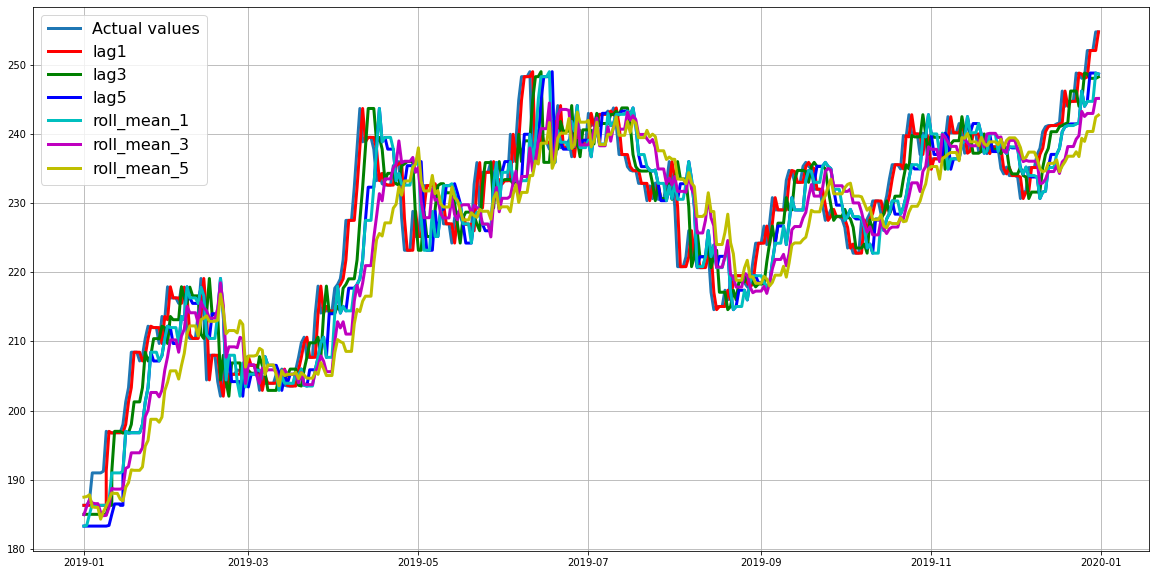

In [236]:
plt.figure(figsize=(20, 10))
plt.plot(sber_stocks.loc['2019', 'Close'], linewidth=3, label="Actual values")
plt.plot(sber_stocks.loc['2019', 'lag1'], "r", linewidth=3, label='lag1')
plt.plot(sber_stocks.loc['2019', 'lag3'], "g", linewidth=3, label='lag3')
plt.plot(sber_stocks.loc['2019', 'lag5'], "b", linewidth=3, label='lag5')
plt.plot(sber_stocks.loc['2019', 'roll_mean_1'], "c", linewidth=3, label='roll_mean_1')
plt.plot(sber_stocks.loc['2019', 'roll_mean_3'], "m", linewidth=3, label='roll_mean_3')
plt.plot(sber_stocks.loc['2019', 'roll_mean_5'], "y", linewidth=3, label='roll_mean_5')
plt.legend(prop={'size':16})
plt.grid(True)
plt.show()